<a href="https://colab.research.google.com/github/AmartyaBarua/Kaggle-CareerCon-2019/blob/master/akb453_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CareerCon 2019 - Help Navigate Robots

##Introduction

---



---



The goal of this notebook is to create a model that can identify different types of floors (i.e. concrete, wood, carpet etc.) using data collected from Inertial Measurement Units (IMU sensors). The data was collected while driving a small robot on different types of floors.

Different features from the data are generated based on the physics based model of the system, especially the equations of motions, as well as the control system response of the robot as it travels over different surface type. This data is then used to create model using Random Forest Classifier.

This notebook highlights the new features that are used, the rationale behind the decisions and the improvements that are observed.

##Prior Works

---



---



There are other existing notebooks on the [Kaggle website](https://www.kaggle.com/c/career-con-2019/notebooks) that use Random Forest Classifier to predict floor types. However, in this notebook, different features are used and these features are selected based on the physics based model of the robot. The parameters of the classifier are tuned to investiage the effects on the accuracy of the model as well.

Some notebooks on the Kaggle website provides aesthetically pleasing data visualisation tools. Some of these tools are used here to visualise the data during the data exploration phase.

##Data Exploration

---



---



In this section, the data is explored to create a feature generation strategy. We begin by importing some useful libraries in python.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import time as time

Now, the data is loaded for exploration

In [0]:
X_train = pd.read_csv('X_train_new.csv',index_col=0)
y_train = pd.read_csv('y_train_new.csv',index_col=0)
X_test = pd.read_csv('X_test_new.csv',index_col=0)
y_test = pd.read_csv('y_test_new.csv',index_col=0)
stat = pd.read_csv('X_train_new.csv',index_col=0)

Let's look at which training features are available from the very beginning.

In [0]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [0]:
X_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
485120,3790_0,3790,0,0.70992,0.68801,0.10876,0.10405,-0.87528,0.138350,0.037472,-2.4550,-0.89309,-20.6040
485121,3790_1,3790,1,0.70968,0.68818,0.10901,0.10429,-0.28090,0.046629,-0.225470,-9.9598,2.35790,-31.4030
485122,3790_2,3790,2,0.70967,0.68836,0.10872,0.10348,0.63630,0.297700,-0.063138,9.2911,-0.23731,-29.5370
485123,3790_3,3790,3,0.70975,0.68843,0.10819,0.10303,0.96157,0.106670,-0.127410,-12.8950,7.27000,1.6024
485124,3790_4,3790,4,0.70968,0.68858,0.10784,0.10289,0.28418,-0.101810,-0.140990,13.9830,8.90370,13.2140


###Visual Inspection

Each feature in the training and test data is plotted to visually compare both of the sets. Both sets seems to be similar with no obvious outliers. This is done prior to making a model to eliminate the possibility of bad test data.

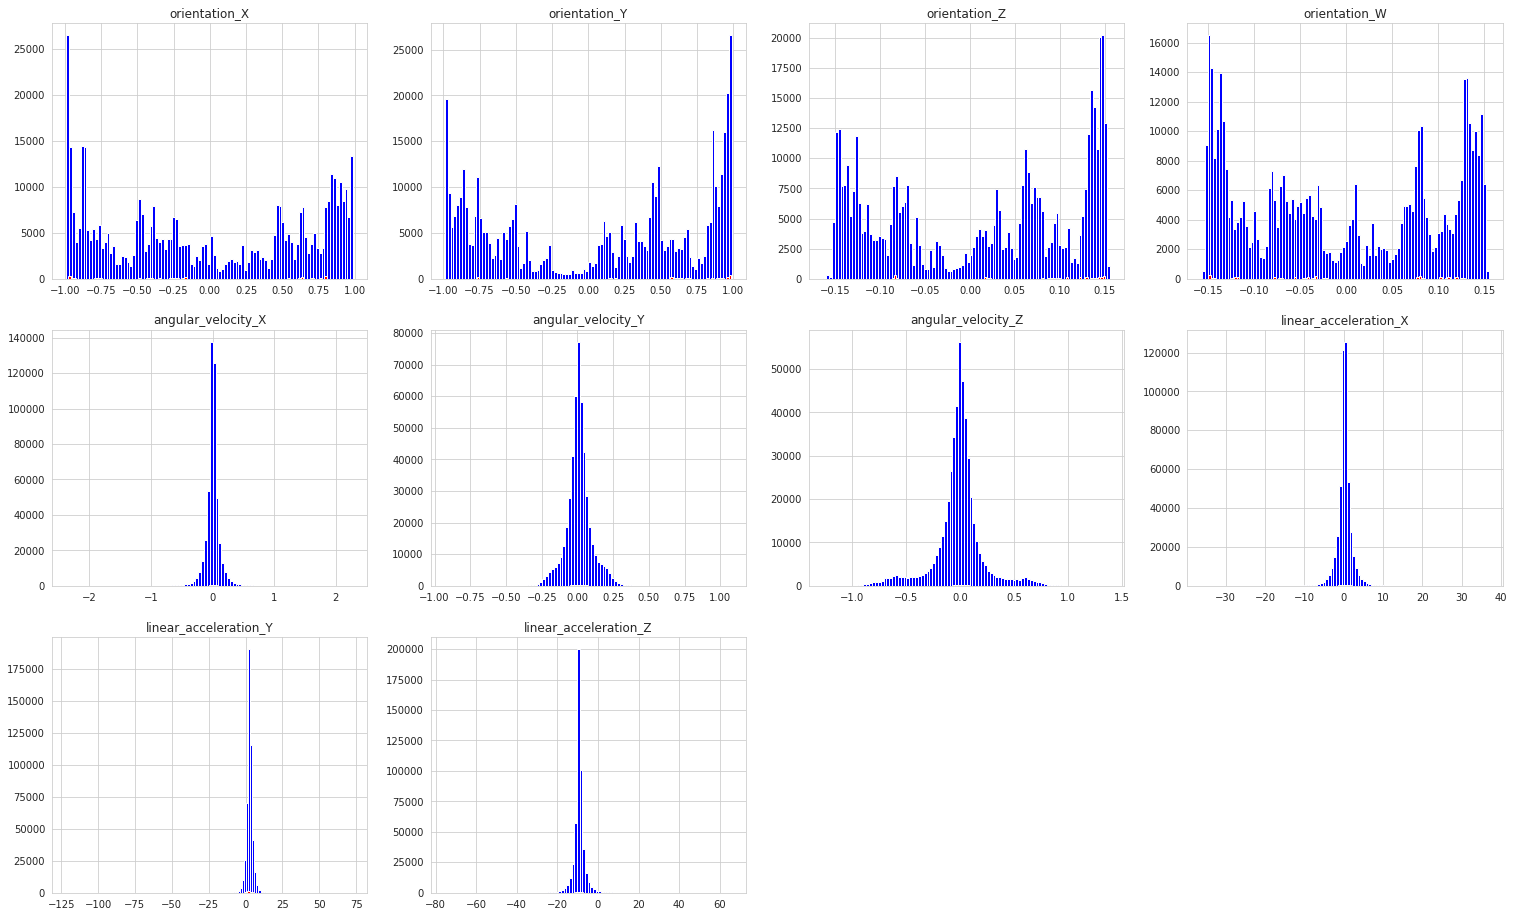

In [0]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(X_train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(X_train[col], color='blue', bins=100)
    plt.hist(X_test[col], color='red', bins=100)
    plt.title(col)

Some important information is provided in the challenge description. For example, each measurement series has an unique ID and contains 128 measurements from 10 sensors (features). Each measurement also has an unique number within the series. This information will be used in the feature generation phase.

We now plot the data from a randomly chosen series to visually determine if there are any strong correlations among the features. We see that both orientation_X and orientation_Y decrease simultaneously. There are no other obvious patterns in the plots, but please note the cyclic nature of the angular velocities. This was one of the key information used in feature generation.

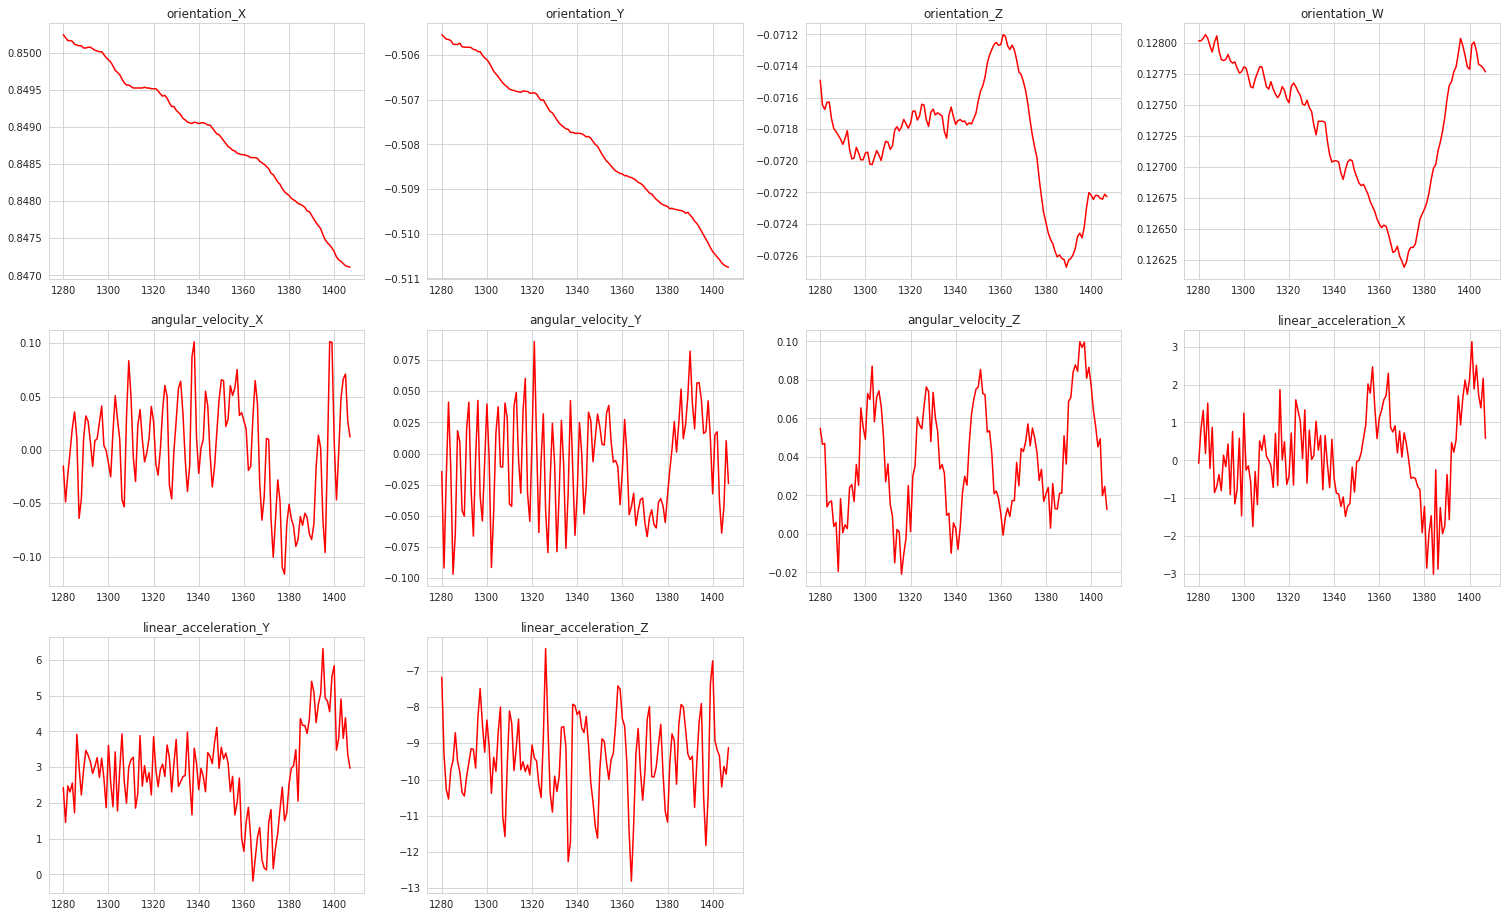

In [0]:
plt.figure(figsize=(26,16))
for i,col in enumerate(X_train.columns[3:]):
  plt.subplot(3,4,i+1)
  plt.plot(X_train.loc[X_train['series_id']==10,col],color='red')
  plt.title(col)

The correlation between orientation_X and orientation_Y that was observed in time series 10, does that exist across all the series? Let's find out how many unique series are in the training set.

In [0]:
X_train['series_id'].nunique()

3790

If we wanted to visually inspect and find correlations in every time series, we have to inspect 3790 plots. That is a lot of plots! Let's look at the correlation matrix of the entire training set instead.

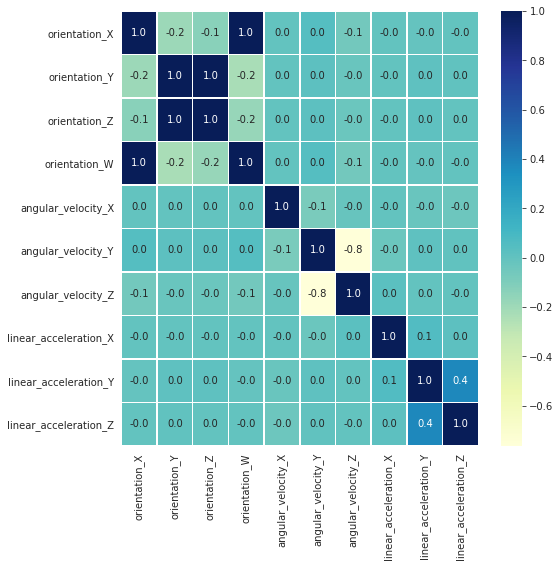

In [0]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(X_train.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="YlGnBu")

We see that the same strong correlation between orientation_X and orientation_Y in the time series 10 is very weak througout training set. There are, however, strong correlations between the angular_velocity_Y and angular_velocity_Z, and linear_acceleration_Y and lineary_acceleration_Z.

We know that a spinning top becomes unstable when its angular velocity decreases. Is it possible that the robot becomes unstable (an increase in the angular_velocity_Z) as it slows down from a turn (a decrease in the angular_velocity_Y)? The correlation between the linear_acceleration_Y and linear_acceleration_Z is not very strong, but still there.

According to [this post](https://www.kaggle.com/c/career-con-2019/discussion/87239), there is a strong correlation between the quaternions and the surface type. We have seen that there is strong correlation between angular velocities (Y and Z) and a cyclic pattern in the angular velocities. Are we dealing with a self balancing robot, that is trying to balance itself on different surface type as it drives around. If so, the orientation of the robot might be coupled to the surface type via friction (i.e. different coefficients of friction).

In the following sections we will generate additional features after examining the equations of motion that govern the inverted pendulum system (related to segway, booster rocket control system etc.). Inverted pendulum model has also been used to understand bipedal (human walking) motion. We will also remove the quaternions in order eliminate any direct effect on prediction accuracy.

##Feature Generation

---



---



We will change the quaternions to the roll, pitch and yaw. The function below also return the sine and cosine of each of the angle, but the rationale behind these features will be given later.

In [0]:
def quatToEuler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    sinX = math.degrees(math.sin(math.radians(X)))
    sinY = math.degrees(math.sin(math.radians(Y)))
    sinZ = math.degrees(math.sin(math.radians(Z)))

    cosX = math.degrees(math.cos(math.radians(X)))
    cosY = math.degrees(math.cos(math.radians(Y)))
    cosZ = math.degrees(math.cos(math.radians(Z)))

    return X, Y, Z, sinX, sinY, sinZ, cosX, cosY, cosZ

def changeAngle(frame):
    x, y, z, w = frame['orientation_X'].tolist(), frame['orientation_Y'].tolist(), frame['orientation_Z'].tolist(), frame['orientation_W'].tolist()
    eulx, euly, eulz, snx, sny, snz, cnx, cny, cnz = [], [], [], [], [], [], [], [], []
    for i in range(len(x)):
      xx, yy, zz, sinX, sinY, sinZ, cosX, cosY, cosZ = quatToEuler(x[i], y[i], z[i], w[i])
      eulx.append(xx)
      euly.append(yy)
      eulz.append(zz)
      snx.append(sinX)
      sny.append(sinY)
      snz.append(sinZ)
      cnx.append(cosX)
      cny.append(cosY)
      cnz.append(cosZ)
    frame['euler_x'] = eulx
    frame['euler_y'] = euly
    frame['euler_z'] = eulz

    # add the sin of theta
    frame['sin_euler_x'] = snx
    frame['sin_euler_y'] = sny
    frame['sin_euler_z'] = snz
    # add the cos of theta
    frame['cos_euler_x'] = cnx
    frame['cos_euler_y'] = cny
    frame['cos_euler_z'] = cnz

    return frame

In [0]:
%%time
X_train = changeAngle(X_train)
X_test = changeAngle(X_test)

# the stat data frame is used to visualise the distribution of each feature to
# understand the impact of each feature on prediction
stat = changeAngle(stat)
print(X_train.shape)

(485120, 22)
CPU times: user 4.73 s, sys: 155 ms, total: 4.88 s
Wall time: 4.92 s


We now look at the distribution of the features across each surface type. We ignore the quaternions and focus on the roll, pitch and yaw instead. The function below plots each feature across different floors on each of the subplots.

In [0]:
# source: https://www.kaggle.com/jesucristo/1-smart-robots-most-complete-
# notebook#Data-exploration

def plot_feature_class_distribution(classes,tt, features,a=7,b=3):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

We see that, based on the distribution curves, different components (X,Y and Z) of the linear acceleration, angular velocity along with the calculated pitch (euler_z) and sin(z) migh have the biggest impact on the prediction. The distribution of the euler_z seems to indicate that the robot might have been trying to balance itself differently on different surface (i.e. the effect of friction on the balance was different for each floor type). To find out if it is indeed a possbility, we look at the equations of motion that govern an inverted pendulum system in the following section.

<Figure size 432x288 with 0 Axes>

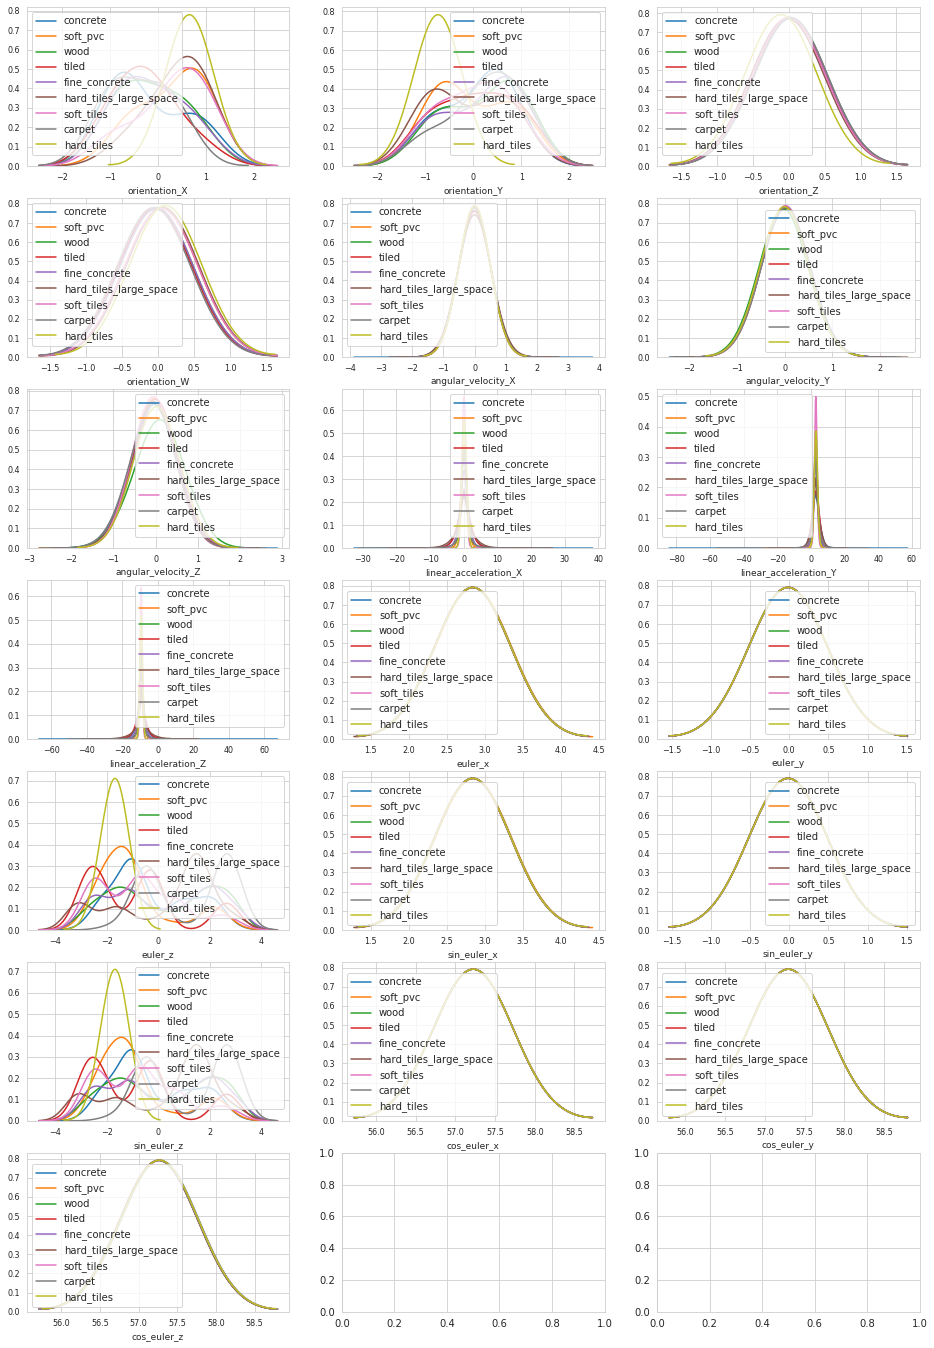

In [0]:
# source: https://www.kaggle.com/jesucristo/1-smart-robots-most-complete-
# notebook#Data-exploration

features = stat.columns.values[3:]
classes = (y_train['surface'].value_counts()).index
aux = stat.merge(y_train, on='series_id', how='inner')
plot_feature_class_distribution(classes, aux, features)

###Inverted Pendulum: Equations of Motion



The inverted pendulum system is composed of a pendulum, with mass $m_{p}$, connected to a cart, with mass $m_{c}$, with a weightless rod of length $L$. See figure below. The goal is to keep the pendulum upright and balanced as the cart moves horizontally. $\theta$ is the angular offset of the pendulum from the upright balanced position and $\hat{i}$ and $\hat{j}$ are unit directions. There are some similarities between this system and a self balancing robot - The robot has to balance all the mass above its wheels (or legs) as it drives around and both the cart and the wheels (or legs) of the robot experience friction and it effects the balance.

![](https://drive.google.com/uc?export=view&id=1tbLPgUWxsvAZGF-uObo0ZUJ0BH2qpyfN)

To control the position of the pendulum we need to find out the equations of motion that govern the system. We start with the free body diagrams of pendulum and the cart.

The free body diagram of the cart shows that the summation of horizontal forces, $F$ (friction included), and the horizontal component of tensile force, $Tsin(\theta)$ act on the cart in the horizontal direction ($\hat{i}$). The normal force, $N$ and the weight of the cart, $m_{c}g$ along with the vertical component of the tensile force, $Tcos(\theta)$ act in the vertical direction, $\hat{j}$.
![](https://drive.google.com/uc?export=view&id=1Ocw7ziQJTWSx3-V3riaTt_QCLGo_y7NA)

In the free body diagram of the pendulum we see that the only horizontal force that is acting on the pendulum is the horizontal component of the tensile force, $Tsin(\theta)$. The vertical forces are the weight of the pendulum, $m_{p}g$ and $Tcos({\theta})$
![](https://drive.google.com/uc?export=view&id=17lSVV5NyKziVpnj7ve1z8UBTxUoH0dT2)

We can express these equations in terms of the states, the angular offset $\theta$ and the acceleration of the cart $\ddot{x}$. First we use Newton's second law for the horizontal forces acting on the cart and get the following.

$F - Tsin(\theta) = m_{c}\ddot{x}$.  (eq. 0)

Now we do the same for the pendulum, but both in the vertical and horizontal direction.

$\hat{i}$: $Tsin(\theta) = m_{p}a_{px}$.    (eq. 1)

$\hat{j}$: $-Tcos(\theta) - m_{p}g = m_{p}a_{pg}$    (eq. 2)

Then we substitute the acceleration of the pendulum, $a_{p}$, with its horizontal and vertical components - the pendulum acceleation is the summation of the acceleration of the cart and the pendulum's own acceleration with respect to the cart. Since the pendulum is rotating around the cart, the tangential and the radial components of the accelration can be described as following
![](https://drive.google.com/uc?export=view&id=1outgijWH8OdnuqEAko-QAQVteqDFuJbz)

Substituting the result aboove into equation 1 and 2 result in the following equations.

$Tsin(\theta) = m_{p}\ddot{x} - m_{p}L\ddot{\theta}cos(\theta) + m_{p}L\dot{\theta}^{2}sin(\theta)$.      (eq. 3)

$-Tcos(\theta) - m_{p}g = m_{p}L\ddot{\theta}sin(\theta) - m_{p}L\dot{\theta}^{2}cos(\theta)$.    (eq. 4)

We can multiply equation 3 with $cos(\theta)$ and equation 4 with $sin(\theta)$ and then add the two to get the following equation.

$-m_{p}gsin(\theta) = m_{p}\ddot{x}cos(\theta) - m_{p}L\ddot{\theta}$.     (eq. 5)

There is still the unknown tension, $Tsin(\theta)$, in the equation 0 but we can substitute the right hand side of equation 3 and remove the unknown quantity. The result is the following equation.

$F + m_{p}L\ddot{\theta}cos(\theta) - m_{p}L\dot{\theta}^{2}sin(\theta) = (m_{p} + m_{c})\ddot{x}$.    eq(6)

The equations 5 and 6 are expressed in terms of the states, $\theta$ and the linear accelration of the cart, $\ddot{x}$. We can see that linear acceleration of the cart and the change in angular velocity and angle of the pendulum is related to the friction force i.e. the surface type (different coefficient of friction). That means features such as the rate of change in the orientation of the center of mass of the robot and the linear acceleration of the robot might be really useful features. With this in mind we go back to the feature engineering.

A detailed description of the inverted pendulum system can be found [here](http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling).

###Back to Feature Engineering

In the last section we showed that the orientation of the center of mass of the robot and the its linear accelration might be very useful features. However, does our data conform to this inverted pendulum model. Before moving on, we make some assumptions - we don't know the mass, geometric features of the robot or anything about the control system parameters. We assume that the data that is available to us is collected from an IMU located at the center of mass of the robot, i.e. the orientation, angular velocity and linear accelration data describe the state of the robot's center of mass.

To find out if the data does indeed conform to the inverted pendulum model presented here, we plot the orientation of the robot on different surface types. If the robot was actively balancing itself then the pitch, roll and yaw will be contstrained within a narrow range. The figures below show that the range of the orientation on concrete is indeed narrow. Though it is not shown, the range of the orientation is also narrow for other surface types.

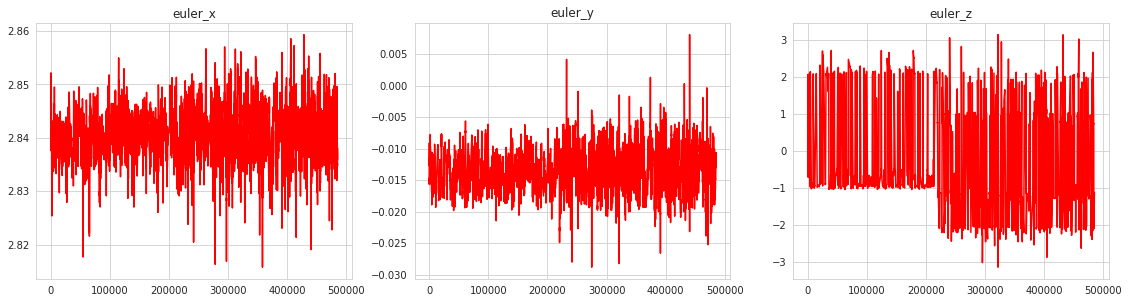

In [0]:
plt.figure(figsize=(26,16))
for i,col in enumerate(aux.columns[13:16]):
  plt.subplot(3,4,i+1)
  plt.plot(aux.loc[aux['surface']=='concrete',col],color="red")
  plt.title(col)

In the figure above, we see that the orientation of the robot is changing frequently between a narrow range. Recall that we saw the cyclic pattern in the angular velocities in the data exploration section, which is linked to the frequent change in orientation seen here. We may have some evidence to believe that we are dealing with a self balancing robot that is actively trying to balance itself as it drives across different surfaces.

Since there is some evidence that the robot is trying to actively balance itself, one can ask the following question - is it possible to use the control system's respose to identify the surface type i.e. does the control system react differently to different surface? It should, if the surface characteristics (roughness or friction) of each surface are drastically different.

With this in mind, we will analyze the roll, pitch and yaw to determine how frequently these change and these will be added to the list of features. The idea is that for different surface type the frequency will be different. The following functions use Fast Fourier Transform to determine the fequency with the largest and amplitude.

In [0]:
def freqMax(s):
  ff = np.fft.rfft(s)
  feqs = np.fft.rfftfreq(len(ff))
  ind = np.argmax(np.abs(ff))
  return feqs[ind]

Recall that the function that was used to convert the quaternions to roll, pitch and yaw also calculated the $sine$ and $cosine$ of the angles. The equations of motions that govern the inverted pendulum also contains the $sine(\theta)$ and the $cos(\theta)$ terms. In the equations, we are dealing with only one angle, $\theta$, since it is a 2-dimensional model. In the physical world, the robot's balance will be affected by 3-dimensional forces, so we are calculating the $sine$ and $cosine$ of all three angles and using them as features.

We also use the information about the distribution of each given feature on different surfaces as new features. This is done to create a feature that uniquely describes a surfaces. For example, it may help us to find out if the maximum total angular velocity differs across surface types and we can use that to differentiate between surfaces.

We use the mean, median, standard deviation, maximum, minimum, range, ratio between maximum to minimum, average change etc. of each feature to create an unique characteristic (signature) of each surface type. We do this by aggregating the data by series ID since we know that the relationship between surface type and a series ID is 1:1 (given in the data description).

The following function is used to generate the new features.

In [0]:
def featureEng(original):
    
    newFrame = pd.DataFrame()
    
    original['scalr_anglr_vel'] = (original['angular_velocity_X']**2 + original['angular_velocity_Y']**2 +
                             original['angular_velocity_Z']**2)** 0.5
    original['scalr_linr_acc'] = (original['linear_acceleration_X']**2 + original['linear_acceleration_Y']**2 +
                             original['linear_acceleration_Z'])**0.5
   
    original['acc_to_vel'] = original['scalr_linr_acc'] / original['scalr_anglr_vel']
    
    for col in original.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        if col in ['euler_x','euler_y','euler_z']:
          newFrame[col + '_fft_max'] = original.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(np.fft.rfft(x))))
          newFrame[col + '_fft_mean'] = original.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.fft.rfft(x))))
          # newFrame[col + '_fft_min'] = original.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(np.fft.rfft(x))))
          newFrame[col + '_fft_std'] = original.groupby(['series_id'])[col].apply(lambda x: np.std(np.abs(np.fft.rfft(x))))
          # newFrame[col + '_fft_range'] = newFrame[col + '_fft_max'] - newFrame[col + '_fft_min']
          newFrame[col + '_freq_max'] = original.groupby(['series_id'])[col].apply(lambda x: freqMax(x))
        newFrame[col + '_mean'] = original.groupby(['series_id'])[col].mean()
        newFrame[col + '_median'] = original.groupby(['series_id'])[col].median()
        newFrame[col + '_max'] = original.groupby(['series_id'])[col].max()
        newFrame[col + '_min'] = original.groupby(['series_id'])[col].min()
        newFrame[col + '_std'] = original.groupby(['series_id'])[col].std()
        newFrame[col + '_range'] = newFrame[col + '_max'] - newFrame[col + '_min']
        newFrame[col + '_maxtoMin'] = newFrame[col + '_max'] / newFrame[col + '_min']
        newFrame[col + '_mean_abs_chg'] = original.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        newFrame[col + '_abs_max'] = original.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        newFrame[col + '_abs_min'] = original.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        newFrame[col + '_abs_avg'] = (newFrame[col + '_abs_min'] + newFrame[col + '_abs_max'])/2
    return newFrame

As promised, before we generate new features, we remove the quaternions from the training and testing sets completely. We use the following for that purpose.

In [0]:
cols = list(X_train.columns.values)
cols.remove('orientation_X')
cols.remove('orientation_Y')
cols.remove('orientation_Z')
cols.remove('orientation_W')
X_train = X_train[cols]
cols = list(X_test.columns.values)
cols.remove('orientation_X')
cols.remove('orientation_Y')
cols.remove('orientation_Z')
cols.remove('orientation_W')
X_test = X_test[cols]

We check the training and test set to verify that the quaternions have indeed been removed from the sets.

In [0]:
X_train.head()

,row_id,series_id,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_x,euler_y,euler_z,sin_euler_x,sin_euler_y,sin_euler_z,cos_euler_x,cos_euler_y,cos_euler_z
0,0_0,0,0,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843272,-0.024668,1.396664,2.842105,-0.024668,1.396526,57.225246,57.295774,57.278758
1,0_1,0,1,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128,2.843199,-0.024662,1.396646,2.842032,-0.024662,1.396508,57.225250,57.295774,57.278758
2,0_2,0,2,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843224,-0.024728,1.396682,2.842057,-0.024728,1.396544,57.225248,57.295774,57.278757
3,0_3,0,3,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843186,-0.024770,1.396721,2.842019,-0.024770,1.396583,57.225250,57.295774,57.278756
4,0_4,0,4,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843195,-0.024784,1.396693,2.842028,-0.024784,1.396555,57.225250,57.295774,57.278757


In [0]:
X_test.head()

,row_id,series_id,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_x,euler_y,euler_z,sin_euler_x,sin_euler_y,sin_euler_z,cos_euler_x,cos_euler_y,cos_euler_z
485120,3790_0,3790,0,-0.87528,0.138350,0.037472,-2.4550,-0.89309,-20.6040,2.839614,-0.011247,1.541163,2.838452,-0.011247,1.540977,57.225427,57.295778,57.275053
485121,3790_1,3790,1,-0.28090,0.046629,-0.225470,-9.9598,2.35790,-31.4030,2.838910,-0.011184,1.541740,2.837748,-0.011184,1.541554,57.225462,57.295778,57.275038
485122,3790_2,3790,2,0.63630,0.297700,-0.063138,9.2911,-0.23731,-29.5370,2.840492,-0.011848,1.542109,2.839329,-0.011848,1.541923,57.225384,57.295778,57.275028
485123,3790_3,3790,3,0.96157,0.106670,-0.127410,-12.8950,7.27000,1.6024,2.841893,-0.011718,1.542072,2.840728,-0.011718,1.541886,57.225314,57.295778,57.275029
485124,3790_4,3790,4,0.28418,-0.101810,-0.140990,13.9830,8.90370,13.2140,2.842590,-0.011368,1.542335,2.841424,-0.011368,1.542148,57.225280,57.295778,57.275022


Now we generate the new features using the function described previously.

In [0]:
%%time
X_train = featureEng(X_train)
X_test = featureEng(X_test)
print(X_train.shape)

(3790, 210)
CPU times: user 1min 1s, sys: 640 ms, total: 1min 2s
Wall time: 1min 1s


##Model Selection

---



---



Before we begin, let's look at the equations of motions that govern the inverted pendulum system. These are non-linear equations. The $sine$ and $cosine$ of the roll, pitch and yaw are also not linear. These are some features we are using. So, we need a model that can work with non-linear features. Also, $sine$ and $cosine$ of these angles can be highly similar (a $cosine$ function is the same as a $sine$ function shifted by 90 degrees).

Random Forest Classifier works well with non-linear features and features that are highly similar to each other. Our features are also on various scales and Random Forest work well with this kind of features too. We don't know anything about the precision and the accuracy of the IMU. Randome Forest Classifier is robust with respect to noisy data. In the following section, we briefly describe the Random Forest Classifier.

###Random Forest Classifier

Random Forest Classifier is an ensemble of larger number of individual decision trees. Each individual tree returns a class prediction and the class with most votes is the final prediction. Since there is low correlation between the trees, the predictions are more accurate. Each tree implements a recursive binary partition of the input feature space. The partition occurs based on tests that involves the features and the corresponding threshold values.

Since, we are already using features that are aggregated characteristics of each original features i.e. mean angular velcity, max angular velocity, max frequency of change in orientation etc. for each floor type over several time series, these features when taken together create an unique signature for each surface type. When measured across several time series for a given surface type, these signatures should be located very close to each other (considering error propagation from the accuracy and precision of the IMU). Using a Random Forest Classifier will be a good option since the feature space can be partitioned easily.

##Training

---



---



Before we can begin training the model we need to convert the name of the surfaces (categorical text data) to numerical data. For example, map "concrete" to 1, "carpet" to 2 etc.

In [0]:
lblenc = LabelEncoder()
y_train['surface'] = lblenc.fit_transform(y_train['surface'])

Next, we replace infinities, and NaN values with zeroes. We do this in the case some of the results of the feature generation are the former values.

In [0]:
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)
X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)

The following are used to check if there are any very large values in the training or test sets.

In [0]:
X_train.iloc[np.where(X_train.values >= np.finfo(np.float32).max)]

""
series_id


In [0]:
X_test.iloc[np.where(X_test.values >= np.finfo(np.float32).max)]

""
series_id


To train the model we split the training set into several training and cross validation sets using the Scikit-learn StratifiedKFold() function. The training and test set, after the feature generation stage, no longer contain any time series, but only the unique signatures for each surface type (discussed previously). As such, this splitting strategy should not be prone to data leak due to temporal dependency discussed [here](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9).

Then we fit the model and determine the model accuracy on the cross validation set. For each model, we predict the surface type probability (divided by the number of splits since the split is random and we do not have the complete feature distribution of the entire set at each model fitting) based on the test data set. Ultimately, we choose the maximum probability of each surface type from the set model predictions.

In [0]:
def cvRFC(X, y, X_test, k):
    folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=2019)
    y_test = np.zeros((X_test.shape[0], 9))
    y_cv_predict = np.zeros((X.shape[0]))
    cv_score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        md =  RandomForestClassifier(n_estimators = 500, n_jobs = -1)
        # train model
        md.fit(X.iloc[train_idx], y[train_idx])
        # cv prediction of the current model
        y_cv_predict[val_idx] = md.predict(X.iloc[val_idx])
        # prediction on the test data of the current model
        y_test += md.predict_proba(X_test) / folds.n_splits
        # cv score of the current model
        cv_score += md.score(X.iloc[val_idx], y[val_idx])
        print('Fold: {} score: {}'.format(i,md.score(X.iloc[val_idx], y[val_idx])))
    print('Avg Accuracy', cv_score / folds.n_splits) 
        
    return y_cv_predict, y_test, md

Let's run the model and see how it performs.

In [0]:
%%time
y_cv_predict, y_test, md = cvRFC(X_train, y_train['surface'], X_test, k= 50)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 21 members, which is less than n_splits=50.
  % (min_groups, self.n_splits)), UserWarning)


Fold: 0 score: 0.9210526315789473
Fold: 1 score: 0.8289473684210527
Fold: 2 score: 0.8552631578947368
Fold: 3 score: 0.9210526315789473
Fold: 4 score: 0.881578947368421
Fold: 5 score: 0.8289473684210527
Fold: 6 score: 0.868421052631579
Fold: 7 score: 0.9078947368421053
Fold: 8 score: 0.9210526315789473
Fold: 9 score: 0.8947368421052632
Fold: 10 score: 0.8552631578947368
Fold: 11 score: 0.8947368421052632
Fold: 12 score: 0.881578947368421
Fold: 13 score: 0.8947368421052632
Fold: 14 score: 0.9473684210526315
Fold: 15 score: 0.9078947368421053
Fold: 16 score: 0.8947368421052632
Fold: 17 score: 0.9078947368421053
Fold: 18 score: 0.868421052631579
Fold: 19 score: 0.9342105263157895
Fold: 20 score: 0.9078947368421053
Fold: 21 score: 0.9078947368421053
Fold: 22 score: 0.9210526315789473
Fold: 23 score: 0.8552631578947368
Fold: 24 score: 0.9342105263157895
Fold: 25 score: 0.8421052631578947
Fold: 26 score: 0.8947368421052632
Fold: 27 score: 0.9342105263157895
Fold: 28 score: 0.9210526315789473

The accuracy on the training set is 0.89, but is it an improvement? In the Appendix, there are results based on feature sets where the quaternions, roll, pitch, yaw, frequency of angle change are missing. These are the features that had been added based on the equations of motion of the inverse pendulum system. The accuracy of 0.89 is a significant improvement over 0.59 without the features. Even if we add just the rotation about the Z-axis and the associated frequency of change, the acuuracy goes up to 0.82 (shown in the Appendix).

In [0]:
confusion_matrix(y_cv_predict,y_train['surface'])

array([[154,   9,   0,   0,   0,   0,   0,   3,   0],
       [ 11, 703,  21,   0,  19,  24,   8,  22,  11],
       [  0,   4, 284,   0,   6,   7,   0,   1,   0],
       [  0,   0,   0,   5,   0,   0,   0,   0,   0],
       [  1,  10,   1,   0, 266,   2,   0,   2,   1],
       [  5,  21,  22,   8,   1, 674,   7,   4,  19],
       [  3,   8,   5,   2,   2,   6, 277,   2,   2],
       [  7,   3,   5,   0,   5,   5,   0, 464,  18],
       [  8,  18,  22,   6,   6,  12,   5,  10, 553]])

###Tuning the Hyperparameters

We have seen the improvements due to the addition of the new features, but can we still make improvements by tuning the hyperparameters such as the number of trees in the forest, number of features considered by a tree node etc.?

We start by finding out the parameters that are currently in used by the random forest classifier model.

In [0]:
print(md.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


From these, we choose the following parameters to modify.

In [0]:
n_estimators = [int(x) for x in np.linspace(start=500,stop=2000,num=5)]
max_depth = [int(x) for x in np.linspace(start=20,stop=110,num=4)]
max_depth.insert(0,None)
min_samples_split = [2,5,10]

random_parameter_grid = {'n_estimators': n_estimators,
                         'max_depth': max_depth,
                         'min_samples_split': min_samples_split}

print(random_parameter_grid)

{'n_estimators': [500, 875, 1250, 1625, 2000], 'max_depth': [None, 20, 50, 80, 110], 'min_samples_split': [2, 5, 10]}


Now, we use RandomSearchCV() to find best parameters from the grid. RandomSearchCV() randomly samples a grid of predifened hyperparameter ranges and performs K-Fold cross validation with each combination of values.

In [0]:
%%time
mdRF =  RandomForestClassifier(n_jobs=-1)
md_random = RandomizedSearchCV(estimator=mdRF, param_distributions=random_parameter_grid,n_iter=10,cv=4)
md_random.fit(X_train,y_train['surface'])

CPU times: user 2min 57s, sys: 9.16 s, total: 3min 6s
Wall time: 21min 37s


In [0]:
mD = md_random.best_params_['max_depth']
mSS = md_random.best_params_['min_samples_split']
nES = md_random.best_params_['n_estimators']

Now we train our model with the updated parameters.

In [0]:
def cvRFC_updated(X, y, X_test, k, mD, mSS, nES):
    folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=2019)
    y_test = np.zeros((X_test.shape[0], 9))
    y_cv_predict = np.zeros((X.shape[0]))
    cv_score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        md =  RandomForestClassifier(n_estimators = nES, min_samples_split= mSS, max_depth= mD, n_jobs = -1)
        # train model
        md.fit(X.iloc[train_idx], y[train_idx])
        # cv prediction of the current model
        y_cv_predict[val_idx] = md.predict(X.iloc[val_idx])
        # prediction on the test data of the current model
        y_test += md.predict_proba(X_test) / folds.n_splits
        # cv score of the current model
        cv_score += md.score(X.iloc[val_idx], y[val_idx])
        print('Fold: {} score: {}'.format(i,md.score(X.iloc[val_idx], y[val_idx])))
    print('Avg Accuracy', cv_score / folds.n_splits) 
        
    return y_cv_predict, y_test, md

In [0]:
%%time
y_cv_predict_updated, y_test_updated, md_updated = cvRFC_updated(X_train, y_train['surface'], X_test, k= 50, mD= mD, mSS= mSS, nES= nES)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 21 members, which is less than n_splits=50.
  % (min_groups, self.n_splits)), UserWarning)


Fold: 0 score: 0.9078947368421053
Fold: 1 score: 0.8289473684210527
Fold: 2 score: 0.8552631578947368
Fold: 3 score: 0.9342105263157895
Fold: 4 score: 0.881578947368421
Fold: 5 score: 0.8289473684210527
Fold: 6 score: 0.881578947368421
Fold: 7 score: 0.9078947368421053
Fold: 8 score: 0.9210526315789473
Fold: 9 score: 0.8947368421052632
Fold: 10 score: 0.868421052631579
Fold: 11 score: 0.8947368421052632
Fold: 12 score: 0.8947368421052632
Fold: 13 score: 0.8947368421052632
Fold: 14 score: 0.9473684210526315
Fold: 15 score: 0.9078947368421053
Fold: 16 score: 0.8947368421052632
Fold: 17 score: 0.9078947368421053
Fold: 18 score: 0.868421052631579
Fold: 19 score: 0.9210526315789473
Fold: 20 score: 0.9210526315789473
Fold: 21 score: 0.9078947368421053
Fold: 22 score: 0.9342105263157895
Fold: 23 score: 0.868421052631579
Fold: 24 score: 0.9342105263157895
Fold: 25 score: 0.8421052631578947
Fold: 26 score: 0.8947368421052632
Fold: 27 score: 0.9473684210526315
Fold: 28 score: 0.9078947368421053


In [0]:
confusion_matrix(y_cv_predict_updated,y_train['surface'])

array([[154,   8,   0,   0,   0,   0,   0,   3,   0],
       [ 12, 708,  20,   0,  19,  23,   8,  22,  12],
       [  0,   3, 285,   0,   5,   8,   0,   1,   0],
       [  0,   0,   0,   5,   0,   0,   0,   0,   0],
       [  1,  10,   1,   0, 269,   2,   0,   2,   2],
       [  5,  21,  23,   8,   1, 678,   7,   4,  18],
       [  3,   8,   5,   2,   2,   5, 277,   2,   2],
       [  7,   3,   5,   0,   4,   4,   0, 464,  18],
       [  7,  15,  21,   6,   5,  10,   5,  10, 552]])

Well it doesn't look like the accuracy has increase too much (still 0.89) and we are still using the training set. Let's compare the output of each and the provided test labels.

In [0]:
Ytest = pd.read_csv('y_test_new.csv',index_col=0)

In [0]:
y_test = np.argmax(y_test,axis=1)
y_test_updated = np.argmax(y_test_updated,axis=1)
submission = pd.DataFrame(columns=['series_id','surface'])
submission_updated = pd.DataFrame(columns=['series_id','surface'])
submission['series_id'] = X_test.index.values
submission_updated['series_id'] = X_test.index.values
submission['surface'] = lblenc.inverse_transform(y_test)
submission_updated['surface'] = lblenc.inverse_transform(y_test_updated)

The following shows the prediction difference between the model with tuned parameter vs model without parameter tuning.


In [0]:
tunedVsUntuned = submission_updated.merge(submission,indicator=True,how='outer')
tunedVsUntuned[tunedVsUntuned['_merge']=='right_only']

,series_id,surface,_merge


There is no difference between the models. So we can compare any of these two with the provided test labels.

In [0]:
testVsUntuned = Ytest.merge(submission,indicator=True,how='outer')
testVsUntuned[testVsUntuned['_merge']=='right_only']

,series_id,group_id,surface,_merge
20,3807,NaN,concrete,right_only


Looks like our untuned model has misclassified one surface type out of 20.

##Conclusion

---



---



After observing the model performace, it can be said that the features selected based on the equation of motion resulted in better prediction. There is still room for improvements, for example we could have investigated hyperparameter tuning more, but that could result in over fitting.

##Appendix

---



---



Here we will present the difference in prediction accuracy with different feature selection. First we look at the feature set that does not include the quaternions or any other features based on the equations of motion.

In [0]:
X_train_unmod = pd.read_csv('X_train_new.csv',index_col=0)
y_train_unmod = pd.read_csv('y_train_new.csv',index_col=0)
X_test_unmod = pd.read_csv('X_test_new.csv',index_col=0)
y_test_unmod = pd.read_csv('y_test_new.csv',index_col=0)

In [0]:
cols = list(X_train_unmod.columns.values)
cols.remove('orientation_X')
cols.remove('orientation_Y')
cols.remove('orientation_Z')
cols.remove('orientation_W')
X_train_unmod = X_train_unmod[cols]
cols = list(X_test_unmod.columns.values)
cols.remove('orientation_X')
cols.remove('orientation_Y')
cols.remove('orientation_Z')
cols.remove('orientation_W')
X_test_unmod = X_test_unmod[cols]

In [0]:
%%time
X_train_unmod = featureEng(X_train_unmod)
X_test_unmod = featureEng(X_test_unmod)
print(X_train_unmod.shape)

(3790, 99)
CPU times: user 25.8 s, sys: 71.5 ms, total: 25.9 s
Wall time: 26 s


In [0]:
y_train_unmod['surface'] = lblenc.fit_transform(y_train_unmod['surface'])

In [0]:
X_train_unmod.fillna(0, inplace = True)
X_test_unmod.fillna(0, inplace = True)
X_train_unmod.replace(-np.inf, 0, inplace = True)
X_train_unmod.replace(np.inf, 0, inplace = True)
X_test_unmod.replace(-np.inf, 0, inplace = True)
X_test_unmod.replace(np.inf, 0, inplace = True)

In [0]:
%%time
y_cv_predict_unmod, y_test_unmod, md_unmod = cvRFC(X_train_unmod, y_train_unmod['surface'], X_test_unmod, k= 50)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 21 members, which is less than n_splits=50.
  % (min_groups, self.n_splits)), UserWarning)


Fold: 0 score: 0.618421052631579
Fold: 1 score: 0.631578947368421
Fold: 2 score: 0.6447368421052632
Fold: 3 score: 0.5921052631578947
Fold: 4 score: 0.6052631578947368
Fold: 5 score: 0.6578947368421053
Fold: 6 score: 0.6447368421052632
Fold: 7 score: 0.6447368421052632
Fold: 8 score: 0.5921052631578947
Fold: 9 score: 0.618421052631579
Fold: 10 score: 0.5657894736842105
Fold: 11 score: 0.618421052631579
Fold: 12 score: 0.5921052631578947
Fold: 13 score: 0.5921052631578947
Fold: 14 score: 0.6578947368421053
Fold: 15 score: 0.4868421052631579
Fold: 16 score: 0.618421052631579
Fold: 17 score: 0.6842105263157895
Fold: 18 score: 0.6052631578947368
Fold: 19 score: 0.5921052631578947
Fold: 20 score: 0.631578947368421
Fold: 21 score: 0.5657894736842105
Fold: 22 score: 0.6842105263157895
Fold: 23 score: 0.618421052631579
Fold: 24 score: 0.5657894736842105
Fold: 25 score: 0.618421052631579
Fold: 26 score: 0.5921052631578947
Fold: 27 score: 0.6842105263157895
Fold: 28 score: 0.618421052631579
Fold

Let's look at the accuracy after just adding the roation about the Z-axis and the associated frequency of change. Based on the equations of motion ($\theta$ is measured about $\hat{k}$ or Z-axis) and the distribution shown previously, adding this feature should improve the accuracy quiet a bit. (Z-axis comes out of the paper, orthogonal to both $\hat{i}$ and $\hat{j}$ and denoted by $\hat{k}$). Spoiler: it goes up to 0.82!

In [0]:
X_train_Z = pd.read_csv('X_train_new.csv',index_col=0)
y_train_Z = pd.read_csv('y_train_new.csv',index_col=0)
X_test_Z = pd.read_csv('X_test_new.csv',index_col=0)
y_test_Z = pd.read_csv('y_test_new.csv',index_col=0)

In [0]:
%%time
X_train_Z = changeAngle(X_train_Z)
X_test_Z = changeAngle(X_test_Z)

CPU times: user 2.41 s, sys: 200 ms, total: 2.61 s
Wall time: 2.63 s


In [0]:
cols = list(X_train_Z.columns.values)
cols.remove('orientation_X')
cols.remove('orientation_Y')
cols.remove('orientation_Z')
cols.remove('orientation_W')
cols.remove('euler_x')
cols.remove('euler_y')
cols.remove('sin_euler_x')
cols.remove('sin_euler_y')
cols.remove('cos_euler_x')
cols.remove('cos_euler_y')
X_train_Z = X_train_Z[cols]
cols = list(X_test_Z.columns.values)
cols.remove('orientation_X')
cols.remove('orientation_Y')
cols.remove('orientation_Z')
cols.remove('orientation_W')
cols.remove('euler_x')
cols.remove('euler_y')
cols.remove('sin_euler_x')
cols.remove('sin_euler_y')
cols.remove('cos_euler_x')
cols.remove('cos_euler_y')
X_test_Z = X_test_Z[cols]

In [0]:
X_test_Z.head()

,row_id,series_id,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_z,sin_euler_z,cos_euler_z
485120,3790_0,3790,0,-0.87528,0.138350,0.037472,-2.4550,-0.89309,-20.6040,1.541163,1.540977,57.275053
485121,3790_1,3790,1,-0.28090,0.046629,-0.225470,-9.9598,2.35790,-31.4030,1.541740,1.541554,57.275038
485122,3790_2,3790,2,0.63630,0.297700,-0.063138,9.2911,-0.23731,-29.5370,1.542109,1.541923,57.275028
485123,3790_3,3790,3,0.96157,0.106670,-0.127410,-12.8950,7.27000,1.6024,1.542072,1.541886,57.275029
485124,3790_4,3790,4,0.28418,-0.101810,-0.140990,13.9830,8.90370,13.2140,1.542335,1.542148,57.275022


In [0]:
%%time
X_train_Z = featureEng(X_train_Z)
X_test_Z = featureEng(X_test_Z)
print(X_train_Z.shape)

(3790, 136)
CPU times: user 38.9 s, sys: 430 ms, total: 39.4 s
Wall time: 38.8 s


In [0]:
y_train_Z['surface'] = lblenc.fit_transform(y_train_Z['surface'])

In [0]:
X_train_Z.fillna(0, inplace = True)
X_test_Z.fillna(0, inplace = True)
X_train_Z.replace(-np.inf, 0, inplace = True)
X_train_Z.replace(np.inf, 0, inplace = True)
X_test_Z.replace(-np.inf, 0, inplace = True)
X_test_Z.replace(np.inf, 0, inplace = True)

In [0]:
%%time
y_cv_predict_Z, y_test_Z, md_Z = cvRFC(X_train_Z, y_train_Z['surface'], X_test_Z, k= 50)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 21 members, which is less than n_splits=50.
  % (min_groups, self.n_splits)), UserWarning)


Fold: 0 score: 0.8289473684210527
Fold: 1 score: 0.7894736842105263
Fold: 2 score: 0.8552631578947368
Fold: 3 score: 0.8947368421052632
Fold: 4 score: 0.8289473684210527
Fold: 5 score: 0.7894736842105263
Fold: 6 score: 0.8026315789473685
Fold: 7 score: 0.8552631578947368
Fold: 8 score: 0.868421052631579
Fold: 9 score: 0.7894736842105263
Fold: 10 score: 0.7894736842105263
Fold: 11 score: 0.868421052631579
Fold: 12 score: 0.868421052631579
Fold: 13 score: 0.868421052631579
Fold: 14 score: 0.8157894736842105
Fold: 15 score: 0.868421052631579
Fold: 16 score: 0.8552631578947368
Fold: 17 score: 0.8421052631578947
Fold: 18 score: 0.8026315789473685
Fold: 19 score: 0.8421052631578947
Fold: 20 score: 0.7763157894736842
Fold: 21 score: 0.8289473684210527
Fold: 22 score: 0.8552631578947368
Fold: 23 score: 0.7894736842105263
Fold: 24 score: 0.8026315789473685
Fold: 25 score: 0.8421052631578947
Fold: 26 score: 0.8552631578947368
Fold: 27 score: 0.8947368421052632
Fold: 28 score: 0.9078947368421053
